<a href="https://colab.research.google.com/github/Erike-Simon/CESAR-AED/blob/main/ProcDados_flights_analysis_final_version_erike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CESAR School Recife**

**Trabalho em equipe**

**Disciplina:** *Processamento de Dados em Larga Escala*

**Alunos:** *Erike Simon, José Aparecido, Marcel Caraciolo*

# Vôos Brasil - 2000 a 2020

Dataset disponível da Agência Nacional de Vôos Civis (ANAC) pela plataforma VRA (Voo Regular Ativo) de Janeiro de 2000 até Agosto 2020.

Dados disponíveis em:
https://www.kaggle.com/datasets/rdewes/voo-regular-ativo-vra-anac.

![Aeroporto Jaboatão dos Guararapes](https://www.recifepasseios.com.br/blog/wp-content/uploads/2019/02/Arquivo_000-2.jpeg)




## Configurações iniciais



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=f6c2be565ace0cd6a0c3e2deaeeb371b0d8da790ec044d083e369ddb2b9c5a3d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import os
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql import SparkSession


os.environ['PYSPARK_SUBMIT_ARGS'] = '\
    --driver-memory 4G \
    --executor-memory 4G \
    pyspark-shell'

In [ ]:
# Criando um cluster local com 1 executor e a quantidade de threads igual a quantidade de cores de CPU disponíveis

spark = SparkSession.builder\
    .master("local[*]")\
    .getOrCreate()
spark

## Import do Dataset

In [ ]:
ROOT_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/proc-dados-larga-escala/spark/archive"

In [ ]:
from pyspark.sql.types import StructType, StringType, TimestampType

# Defina manualmente o esquema
custom_schema = StructType() \
    .add("index", T.IntegerType()) \
    .add("sigla_empresa", StringType()) \
    .add("numero_voo", T.IntegerType()) \
    .add("di", T.IntegerType()) \
    .add("tipo_linha", T.IntegerType()) \
    .add("aero_origem", StringType()) \
    .add("aero_destino", StringType()) \
    .add("part_prevista", TimestampType()) \
    .add("part_real", TimestampType()) \
    .add("cheg_prevista", TimestampType()) \
    .add("cheg_real", TimestampType()) \
    .add("situacao_voo", StringType()) \
    .add("justificativa", StringType())

# Leia o arquivo CSV com o esquema personalizado e especificando o separador como ponto e vírgula
flights_df = spark.read.csv(f'{ROOT_DATA_PATH}/arquivo_limpo.csv', header=True, schema=custom_schema, sep=';')
flights_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- sigla_empresa: string (nullable = true)
 |-- numero_voo: integer (nullable = true)
 |-- di: integer (nullable = true)
 |-- tipo_linha: integer (nullable = true)
 |-- aero_origem: string (nullable = true)
 |-- aero_destino: string (nullable = true)
 |-- part_prevista: timestamp (nullable = true)
 |-- part_real: timestamp (nullable = true)
 |-- cheg_prevista: timestamp (nullable = true)
 |-- cheg_real: timestamp (nullable = true)
 |-- situacao_voo: string (nullable = true)
 |-- justificativa: string (nullable = true)



In [ ]:
flights_df.show()

+-----+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+
|index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa|
+-----+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+
|    0|          TBA|      9270|  0|      NULL|       SBSV|        SBFZ|2000-01-25 05:50:00|2000-01-25 05:50:00|2000-01-25 07:20:00|2000-01-25 07:20:00|   Realizado|          nan|
|    1|          PEP|      2960|  0|      NULL|       SBBE|        SBSN|2000-01-29 05:50:00|2000-01-29 05:50:00|2000-01-29 07:30:00|2000-01-29 07:30:00|   Realizado|          nan|
|    2|          PEP|      2960|  0|      NULL|       SBBE|        SBSN|2000-06-01 05:50:00|2000-06-

 **Transformando os dados em arquivo *.parquet***

In [ ]:
%%time

flights_df.write.parquet(f'{ROOT_DATA_PATH}/flights_parquet_df', mode='overwrite')

CPU times: user 1.86 s, sys: 263 ms, total: 2.13 s
Wall time: 6min 18s


In [ ]:
flights_parquet_df = spark.read.parquet(f'{ROOT_DATA_PATH}/flights_parquet_df')
flights_parquet_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- sigla_empresa: string (nullable = true)
 |-- numero_voo: integer (nullable = true)
 |-- di: integer (nullable = true)
 |-- tipo_linha: integer (nullable = true)
 |-- aero_origem: string (nullable = true)
 |-- aero_destino: string (nullable = true)
 |-- part_prevista: timestamp (nullable = true)
 |-- part_real: timestamp (nullable = true)
 |-- cheg_prevista: timestamp (nullable = true)
 |-- cheg_real: timestamp (nullable = true)
 |-- situacao_voo: string (nullable = true)
 |-- justificativa: string (nullable = true)



In [ ]:
flights_parquet_df.count()

20546428

In [ ]:
# Limpando voos que não tem partida prevista e nem chegada prevista

# Primeiro limpando aqueles sem partida prevista
voos = flights_parquet_df.filter(flights_parquet_df.part_prevista.isNotNull())

# Removendo os sem Partida Real
voos = voos.filter(voos.part_real.isNotNull())

# Removendo os sem Chegada Prevista
voos = voos.filter(voos.cheg_prevista.isNotNull())

# Removendo os sem Chegada Real
voos = voos.filter(voos.cheg_real.isNotNull())

voos.count()

16783207

In [ ]:
from pyspark.sql.functions import year, month, day, dayofweek, unix_timestamp

In [ ]:
# Separando Ano, mes e dia
# Ano

voos = voos.withColumn('ano',  year(F.col('part_prevista')))

# Mes
voos = voos.withColumn('mes',  month(F.col('part_prevista')))
# Dia
voos = voos.withColumn('dia',  day(F.col('part_prevista')))

# Classificando o dia da semana
voos = voos.withColumn('dia_da_semana',  dayofweek(F.col('part_prevista')))

voos.show()

+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+
|  index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa| ano|mes|dia|dia_da_semana|
+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+
|5784360|          GLO|      1783|  0|      NULL|       SBBR|        SBGL|2007-02-01 07:40:00|2007-02-01 07:40:00|2007-02-01 09:20:00|2007-02-01 09:20:00|   Realizado|          nan|2007|  2|  1|            5|
|5784361|          ONE|      6311|  0|      NULL|       SBCH|        SBSP|2007-01-24 07:40:00|2007-01-24 07:40:00|2007-01-24 09:05:00|2007-01-24 09:05:00|   Realiza

In [ ]:
### Lendo o arquivo de descrição de siglas de aeroportos
import pandas

aeroportos = pandas.read_excel(f'{ROOT_DATA_PATH}/glossario_de_aerodromo.xls', header=3)
aeroportos = aeroportos.drop('Unnamed: 0', axis=1)

aeroportos = spark.createDataFrame(aeroportos)

aeroportos.show()

+----------+--------------------+--------------------+---+---------------+----------------+
|Sigla OACI|           Descrição|              Cidade| UF|           País|      Continente|
+----------+--------------------+--------------------+---+---------------+----------------+
|      1AON| OUROLANDIA DO NORTE| OURILANDIA DO NORTE| PA|         BRASIL|  AMERICA DO SUL|
|      2NHT|  HOTEL TRANSAMÉRICA|                UNA | BA|         BRASIL|  AMERICA DO SUL|
|      6ASO|             SORRISO|             SORRISO| MT|         BRASIL|  AMERICA DO SUL|
|      CYMX|MONTREAL-MIRABEL ...|             MIRABEL|NaN|         CANADA|AMERICA DO NORTE|
|      CYQB|QUEBEC CITY JEAN ...|QUEBEC JEAN LESAG...|NaN|         CANADA|AMERICA DO NORTE|
|      CYWG|WINNIPEG JAMES AR...|                 NaN|NaN|         CANADA|AMERICA DO NORTE|
|      CYYC|CALGARY INTERNATI...|                 NaN|NaN|         CANADA|AMERICA DO NORTE|
|      CYYZ|TORONTO PEARSON I...|             TORONTO|NaN|         CANADA|AMERIC

## 1.Como varia a média de voos realizados e cancelados ao longo dos anos de 2000 a 2020? De acordo com ANAC vôos atrasados são considerados vôos com partida realizada >= 30 min da partida prevista.

Calculando os atrasos em segundos e armazenando na coluna `'atraso_partida'`

In [ ]:
# Classificando os atrasados (segundos)
voos = voos.withColumn('atraso_partida' , unix_timestamp('part_real') - unix_timestamp('part_prevista'))
voos.show()

+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+
|  index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa| ano|mes|dia|dia_da_semana|atraso_partida|
+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+
|5784360|          GLO|      1783|  0|      NULL|       SBBR|        SBGL|2007-02-01 07:40:00|2007-02-01 07:40:00|2007-02-01 09:20:00|2007-02-01 09:20:00|   Realizado|          nan|2007|  2|  1|            5|             0|
|5784361|          ONE|      6311|  0|      NULL|       SBCH|        SBSP|2007-01-24 07:40:00|2007-01-24

Classificando os voos como atrasados ou não atrasados na coluna **'atrasado'**

In [ ]:
from pyspark.sql.functions import when

# Classificando aqueles acima de 30 minutos (1800segundos)
voos = voos.withColumn('atrasado', when(voos.atraso_partida >= 1800, 'SIM').otherwise('NAO'))
voos.show()

+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|  index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa| ano|mes|dia|dia_da_semana|atraso_partida|atrasado|
+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|5784360|          GLO|      1783|  0|      NULL|       SBBR|        SBGL|2007-02-01 07:40:00|2007-02-01 07:40:00|2007-02-01 09:20:00|2007-02-01 09:20:00|   Realizado|          nan|2007|  2|  1|            5|             0|     NAO|
|5784361|          ONE|      6311|  0|      NULL|       SBCH|       

Calculando e armazenando a porcentagem de atrasos anuais totais.

In [ ]:
from pyspark.sql import functions as F

# Agrupa os voos por ano e calcula a porcentagem de voos atrasados
voos_por_ano = voos.groupBy('ano')\
    .agg(
        F.count('*').alias('total_voos'),
        F.round((F.sum(F.when(voos['atrasado'] == 'SIM', 1).otherwise(0)) / F.count('*') * 100), 2).alias('porcentagem_atrasados')
    )\
    .orderBy('ano')

voos_por_ano.show()

+----+----------+---------------------+
| ano|total_voos|porcentagem_atrasados|
+----+----------+---------------------+
|2000|    709365|                10.04|
|2001|    729362|                11.34|
|2002|    668898|                11.35|
|2003|    530979|                 9.98|
|2004|    531545|                10.18|
|2005|    574807|                12.43|
|2006|    608159|                18.32|
|2007|    641285|                28.09|
|2008|    740108|                15.35|
|2009|    814946|                 9.51|
|2010|    947014|                11.68|
|2011|   1079256|                11.04|
|2012|   1125659|                 9.42|
|2013|   1076071|                 8.05|
|2014|    891655|                  8.2|
|2015|   1069070|                 6.43|
|2016|    952397|                 6.45|
|2017|    853548|                 7.39|
|2018|    976740|                  8.1|
|2019|    965181|                 7.67|
+----+----------+---------------------+
only showing top 20 rows



Exibindo o resultado

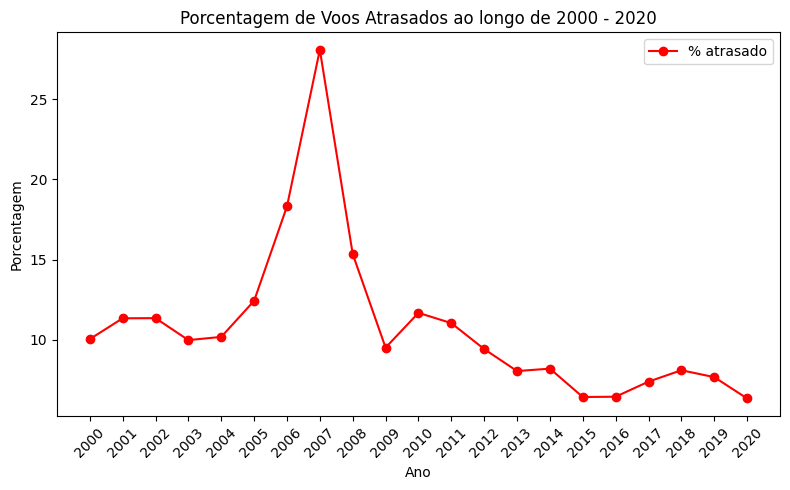

In [ ]:
import matplotlib.pyplot as plt

# Extrai os dados do dataframe
years = voos_por_ano.select('ano').rdd.flatMap(lambda x: x).collect()
percent_atrasado = voos_por_ano.select('porcentagem_atrasados').rdd.flatMap(lambda x: x).collect()

# Plot do gráfico
plt.figure(figsize=(8, 5))
plt.plot(years, percent_atrasado, marker='o', color='red', label='% atrasado')
plt.title('Porcentagem de Voos Atrasados ao longo de 2000 - 2020')
plt.xlabel('Ano')
plt.ylabel('Porcentagem')
plt.legend()
plt.xticks(years, rotation=45)  # Garantir que todos os anos estejam no eixo x
plt.tight_layout()
plt.show()

Curiosidamente, o pior período foi durante o apagão aéreo que atingiu o país entre 2007 e 2008, mais informações em : https://pt.wikipedia.org/wiki/Apag%C3%A3o_a%C3%A9reo_de_2006

## 2.Saindo do Aeroporto Gilberto Freyre (Recife) quais foram 5 top destinos (aeroportos) ?

In [ ]:
# Filtrando todos os voos cujo Aeroporto de Saída é o de Recife (SBRF)

voos_recife = voos.where(F.col('aero_origem') == 'SBRF')
voos_recife.show()

+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|  index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa| ano|mes|dia|dia_da_semana|atraso_partida|atrasado|
+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|5786149|          GLO|      1565|  0|      NULL|       SBRF|        SBSV|2007-05-01 08:15:00|2007-05-01 08:15:00|2007-05-01 09:25:00|2007-05-01 09:25:00|   Realizado|          nan|2007|  5|  1|            3|             0|     NAO|
|5786182|          GLO|      1565|  0|      NULL|       SBRF|       

In [ ]:
resultado = voos_recife.groupBy('aero_destino').count().orderBy(F.desc('count')).limit(5)
resultado.show()

+------------+-----+
|aero_destino|count|
+------------+-----+
|        SBGR|89056|
|        SBSV|68593|
|        SBFZ|61171|
|        SBGL|55531|
|        SBBR|43409|
+------------+-----+



In [ ]:
# União das tabelas, primeiro aeroporto de origem e depois o de destino
resultado = resultado.withColumn('Sigla OACI', F.col('aero_destino')).join(aeroportos.alias('aero_destino'), how='left', on='Sigla OACI')
resultado.show()

+----------+------------+-----+--------------------+--------------+---+------+--------------+
|Sigla OACI|aero_destino|count|           Descrição|        Cidade| UF|  País|    Continente|
+----------+------------+-----+--------------------+--------------+---+------+--------------+
|      SBGR|        SBGR|89056|GUARULHOS - GOVER...|     GUARULHOS| SP|BRASIL|AMERICA DO SUL|
|      SBSV|        SBSV|68593|DEPUTADO LUÍS EDU...|      SALVADOR| BA|BRASIL|AMERICA DO SUL|
|      SBFZ|        SBFZ|61171|       PINTO MARTINS|     FORTALEZA| CE|BRASIL|AMERICA DO SUL|
|      SBGL|        SBGL|55531|AEROPORTO INTERNA...|RIO DE JANEIRO| RJ|BRASIL|AMERICA DO SUL|
|      SBBR|        SBBR|43409|PRESIDENTE JUSCEL...|      BRASÍLIA| DF|BRASIL|AMERICA DO SUL|
+----------+------------+-----+--------------------+--------------+---+------+--------------+



Resposta: Guarulhos (SP), Salvador (BA), Fortaleza(CE), Rio de Janeiro(RJ), Brasilia(DF).

## 3.Considerando como o Aeroporto Gilberto Freyre (Recife) (código SBRF) como origem, quais as top 3 companhias que mais atrasaram por ano entre 2015 e 2020?

In [ ]:
voos_recife = voos.where(F.col('aero_origem') == 'SBRF')
voos_recife.show()

+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|  index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa| ano|mes|dia|dia_da_semana|atraso_partida|atrasado|
+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|5786149|          GLO|      1565|  0|      NULL|       SBRF|        SBSV|2007-05-01 08:15:00|2007-05-01 08:15:00|2007-05-01 09:25:00|2007-05-01 09:25:00|   Realizado|          nan|2007|  5|  1|            3|             0|     NAO|
|5786182|          GLO|      1565|  0|      NULL|       SBRF|       

In [ ]:
voos_recife_atrasados = voos.where(F.col('atrasado') == 'SIM')

voos_recife_atrasados.show()

+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|  index|sigla_empresa|numero_voo| di|tipo_linha|aero_origem|aero_destino|      part_prevista|          part_real|      cheg_prevista|          cheg_real|situacao_voo|justificativa| ano|mes|dia|dia_da_semana|atraso_partida|atrasado|
+-------+-------------+----------+---+----------+-----------+------------+-------------------+-------------------+-------------------+-------------------+------------+-------------+----+---+---+-------------+--------------+--------+
|5784374|          GLO|      1853|  0|      NULL|       SBBR|        SBGR|2007-01-22 07:40:00|2007-01-22 10:00:00|2007-01-22 09:10:00|2007-01-22 11:35:00|   Realizado|           AR|2007|  1| 22|            2|          8400|     SIM|
|5784377|          GLO|      7458|  0|      NULL|       SBFL|       

In [ ]:
voos_atrasados_por_ano = voos_recife_atrasados.groupBy(['ano', 'sigla_empresa'])\
    .agg({'atraso_partida': 'sum'})\
    .withColumnRenamed('sum(atraso_partida)', 'total_atraso')\
    .orderBy('ano', 'total_atraso', ascending=[True, False])

voos_atrasados_por_ano.show()

+----+-------------+------------+
| ano|sigla_empresa|total_atraso|
+----+-------------+------------+
|2000|          PEP|128180941740|
|2000|          VRG|   993681660|
|2000|          VSP|   497181060|
|2000|          BLC|   465193140|
|2000|          TAM|   303004860|
|2000|          NES|   281295600|
|2000|          TBA|   200823540|
|2000|          JAL|   152202360|
|2000|          ITB|   143251440|
|2000|          RSL|   102310500|
|2000|          ARG|    93361500|
|2000|          AFR|    74238480|
|2000|          TAP|    59256600|
|2000|          TVJ|    58240620|
|2000|          LLB|    48316260|
|2000|          TIB|    37051860|
|2000|          TTL|    33826860|
|2000|          LAN|    26565180|
|2000|          COA|    25936860|
|2000|          PAC|    19400940|
+----+-------------+------------+
only showing top 20 rows



In [ ]:
# Obtendo os top 3 companhias por ano

from pyspark.sql.window import Window

window_spec = Window.partitionBy('ano').orderBy(F.col('total_atraso').desc())
top3_empresas_atraso = voos_atrasados_por_ano.withColumn('rank', F.row_number().over(window_spec))

# Selecionar apenas as três maiores em atraso
top3_empresas_atraso = top3_empresas_atraso.filter((F.col('ano') >= 2015) & (F.col('rank') <= 3))

top3_empresas_atraso.show()

+----+-------------+------------+----+
| ano|sigla_empresa|total_atraso|rank|
+----+-------------+------------+----+
|2015|          AZU|  1906897500|   1|
|2015|          GLO|  1006630740|   2|
|2015|          TAM|   751261320|   3|
|2016|          AZU|  6228778140|   1|
|2016|          TAM|  4501681320|   2|
|2016|          GLO|  2084384280|   3|
|2017|          AZU|   874012140|   1|
|2017|          TAM|   669466800|   2|
|2017|          LTG|   538176900|   3|
|2018|          TAM|  1530679380|   1|
|2018|          AZU|  1356655020|   2|
|2018|          GLO|   781273020|   3|
|2019|          AZU|  1467116160|   1|
|2019|          TAM|  1257104460|   2|
|2019|          GLO|  1210813560|   3|
|2020|          GLO|   608753100|   1|
|2020|          AZU|   547981260|   2|
|2020|          TAM|   224715960|   3|
+----+-------------+------------+----+



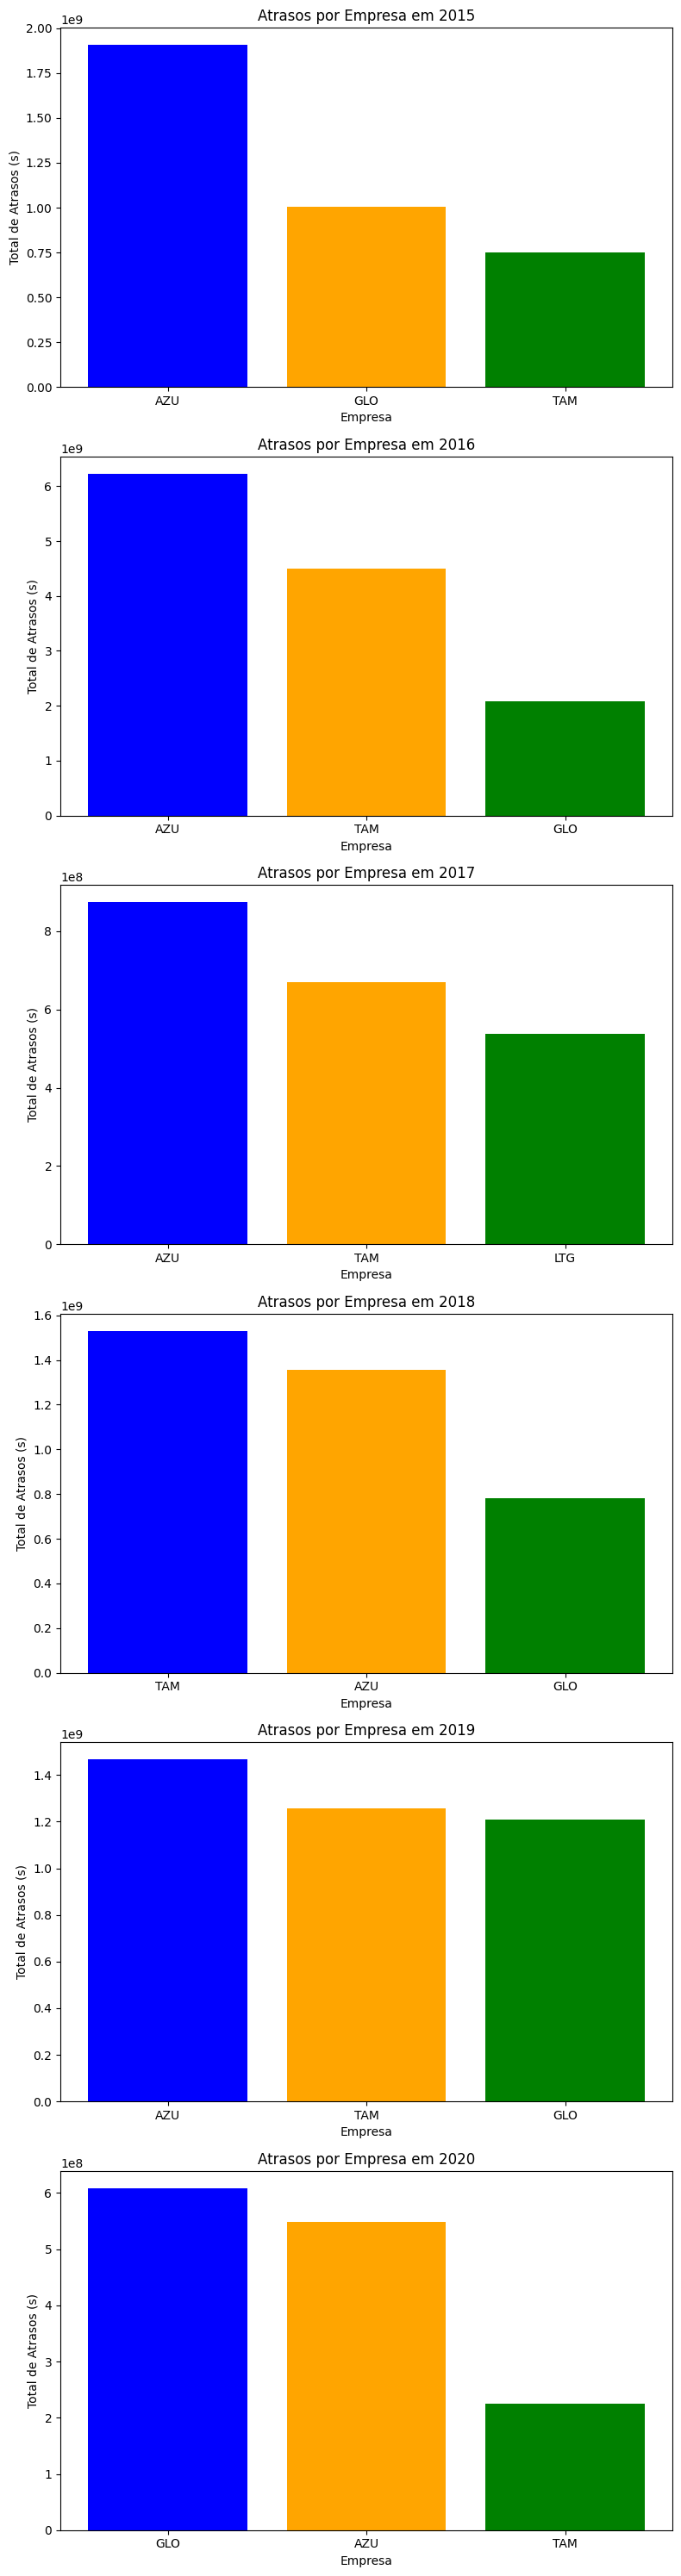

In [ ]:
# Coletando os dados para o gráfico
anos = top3_empresas_atraso.select('ano').distinct().orderBy('ano').rdd.flatMap(lambda x: x).collect()
empresas = top3_empresas_atraso.select('sigla_empresa').distinct().rdd.flatMap(lambda x: x).collect()

# Cria o gráfico de barras
fig, axs = plt.subplots(len(anos), figsize=(8, 5 * len(anos)))

for i, ano in enumerate(anos):
    dados_ano = top3_empresas_atraso.filter(F.col('ano') == ano).toPandas()
    axs[i].bar(dados_ano['sigla_empresa'], dados_ano['total_atraso'], color=['blue', 'orange', 'green'])
    axs[i].set_title(f'Atrasos por Empresa em {ano}')
    axs[i].set_xlabel('Empresa')
    axs[i].set_ylabel('Total de Atrasos (s)')

plt.tight_layout()
plt.show()

## 4.Quais aeroportos tiveram maior crescimento de seu numero de voos realizados entre 2000 e 2020?

In [ ]:
# Calculando o número de voos por aeroporto em cada ano
voos_por_aeroporto_por_ano = voos.groupBy("aero_origem", "ano").agg(F.count("numero_voo").alias("num_voos"))

voos_por_aeroporto_por_ano.show()

+-----------+----+--------+
|aero_origem| ano|num_voos|
+-----------+----+--------+
|       SWRD|2007|    1202|
|       GCLP|2005|      23|
|       SBKG|2006|     375|
|       SUMU|2003|    1634|
|       SBTE|2007|    3010|
|       SBUG|2007|     222|
|       SBMG|2007|    2142|
|       SWTP|2005|     133|
|       FNLU|2006|     103|
|       SNVS|2000|     375|
|       SNTI|2000|     464|
|       EHAM|2001|     339|
|       MMUN|2001|     408|
|       KEWR|2002|     368|
|       SWGN|2002|     361|
|       SYCJ|2007|     105|
|       SBPL|2008|    1196|
|       CYYZ|2008|     387|
|       SLPS|2005|      88|
|       SBJF|2006|     921|
+-----------+----+--------+
only showing top 20 rows



In [ ]:
# Calculando o número de voos por aeroporto no ano anterior
window_spec = Window.partitionBy("aero_origem").orderBy("ano")

voos_por_aeroporto_por_ano = voos_por_aeroporto_por_ano.withColumn("num_voos_ano_anterior", F.lag("num_voos", 1).over(window_spec))
voos_por_aeroporto_por_ano.show()

+-----------+----+--------+---------------------+
|aero_origem| ano|num_voos|num_voos_ano_anterior|
+-----------+----+--------+---------------------+
|       1AON|2000|     145|                 NULL|
|       2NHT|2000|     102|                 NULL|
|       6ASO|2000|       5|                 NULL|
|       CYMX|2019|       1|                 NULL|
|       CYUL|2019|       9|                 NULL|
|       CYUL|2020|      38|                    9|
|       CYVR|2020|       1|                 NULL|
|       CYYZ|2000|     291|                 NULL|
|       CYYZ|2001|     298|                  291|
|       CYYZ|2002|     264|                  298|
|       CYYZ|2003|     274|                  264|
|       CYYZ|2004|     315|                  274|
|       CYYZ|2005|     451|                  315|
|       CYYZ|2006|     365|                  451|
|       CYYZ|2007|     365|                  365|
|       CYYZ|2008|     387|                  365|
|       CYYZ|2009|     308|                  387|


In [ ]:
# Calculando o crescimento do número de voos para cada aeroporto ao longo do tempo
voos_por_aeroporto_por_ano = voos_por_aeroporto_por_ano.withColumn("crescimento", when(voos_por_aeroporto_por_ano["num_voos_ano_anterior"].isNull(), 0)
                                                                .otherwise(
                                                                    (voos_por_aeroporto_por_ano["num_voos"] - voos_por_aeroporto_por_ano["num_voos_ano_anterior"]) / voos_por_aeroporto_por_ano["num_voos_ano_anterior"])
                                                                )

voos_por_aeroporto_por_ano.show()

+-----------+----+--------+---------------------+--------------------+
|aero_origem| ano|num_voos|num_voos_ano_anterior|         crescimento|
+-----------+----+--------+---------------------+--------------------+
|       1AON|2000|     145|                 NULL|                 0.0|
|       2NHT|2000|     102|                 NULL|                 0.0|
|       6ASO|2000|       5|                 NULL|                 0.0|
|       CYMX|2019|       1|                 NULL|                 0.0|
|       CYUL|2019|       9|                 NULL|                 0.0|
|       CYUL|2020|      38|                    9|  3.2222222222222223|
|       CYVR|2020|       1|                 NULL|                 0.0|
|       CYYZ|2000|     291|                 NULL|                 0.0|
|       CYYZ|2001|     298|                  291|0.024054982817869417|
|       CYYZ|2002|     264|                  298|-0.11409395973154363|
|       CYYZ|2003|     274|                  264| 0.03787878787878788|
|     

In [ ]:
# Encontrando os aeroportos que tiveram o maior crescimento de número de voos ao longo do tempo
aeroportos_maior_crescimento = voos_por_aeroporto_por_ano.groupBy("aero_origem").agg(F.round(F.avg("crescimento"), 2).alias("avg_crescimento %")).orderBy("avg_crescimento %", ascending=False)

top10_aeroportos = aeroportos_maior_crescimento.limit(10)
top10_aeroportos.show()

+-----------+-----------------+
|aero_origem|avg_crescimento %|
+-----------+-----------------+
|       SJTC|            39.73|
|       SABE|            33.44|
|       SNBA|            30.75|
|       SANT|            27.35|
|       SBPP|            17.96|
|       SSDO|            13.47|
|       SBUF|            13.44|
|       SBVG|            13.21|
|       SWNK|              9.9|
|       SLCB|             9.62|
+-----------+-----------------+



Coletando a descrição das siglas OACI dos top 10 aeroportos com maior crescimento de voos.

In [ ]:
# Junta os dois DataFrames usando a coluna 'aero_origem' e 'Sigla OACI' como chave de junção
aeroportos_com_descricao = top10_aeroportos.join(aeroportos, top10_aeroportos['aero_origem'] == aeroportos['Sigla OACI'], how='inner')

# Seleciona apenas as colunas 'aero_origem' e 'Descrição'
aeroportos_com_descricao_selecionados = aeroportos_com_descricao.select('aero_origem', 'Descrição')
aeroportos_com_descricao_selecionados.toPandas()

,aero_origem,Descrição
0,SABE,JORGE NEWBERY AIRPORT
1,SANT,TTE. GRAL. BENJAMÃN MATIENZO INTERNATIONAL AI...
2,SBPP,PONTA PORÃ
3,SBUF,PAULO AFONSO
4,SBVG,MAJOR BRIGADEIRO TROMPOWSKY
5,SJTC,MOUSSA NAKHL TOBIAS
6,SLCB,JORGE WILSTERMANN INTERNATIONAL AIRPORT
7,SNBA,CHAFEI AMSEI
8,SSDO,MUNICIPAL FRANCISCO DE MATOS PEREIRA
9,SWNK,NOVO CAMPO


Os 10 aeroportos que tiveram o maior crescimento no número de voos no período de 2000 a 2020:



```
aero_origem	avg_crescimento %
  SJTC	          39.73
  SABE	          33.44
  SNBA	          30.75
  SANT	          27.35
  SBPP	          17.96
  SSDO	          13.47
  SBUF	          13.44
  SBVG	          13.21
  SWNK	           9.90
  SLCB	           9.62
```